In [8]:
import os
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Reading Data using Pandas and SQLite3

In [3]:
# helper function to join tables across different database (.db) files
def join_tables(tables):
    
    df = tables[0]
    for table in tables[1:]:
        df = pd.concat([df, table])
        
    return df.reset_index(drop=True)

# joining all database (.db) files of folder
def get_all_databases(folder):
    
    string_tables = []
    ull_tables = []
    files = os.listdir(folder)
    
    # iterating through all files of folder to append tables
    for file in files:
        path = os.path.join(folder, file)
        con = sqlite3.connect(path)
        string_tables.append(pd.read_sql_query('SELECT * FROM COUNTERS_STRING_TIME_DATA', con))
        ull_tables.append(pd.read_sql_query('SELECT * FROM COUNTERS_ULL_TIME_DATA', con))
        
    # concatenating tables into single DataFrames
    string_df = join_tables(string_tables)
    ull_df = join_tables(ull_tables)
    
    return (string_df, ull_df)

In [4]:
# LAPTOP-MP2GILK8
string_df_0, ull_df_0 = get_all_databases('group3_collected_data')

# DESKTOP-E83M0TM
string_df_1, ull_df_1 = get_all_databases('group3_collected_data_pc_1')

In [6]:
display(string_df_0.head())
display(ull_df_0.head())

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-11-20 21:30:29.491,2,IDC_ARROW,0
1,2021-11-20 21:30:30.578,3,cmd.exe,0
2,2021-11-20 21:30:31.512,2,IDC_SIZEWE,0
3,2021-11-20 21:30:31.847,2,IDC_ARROW,0
4,2021-11-20 21:30:34.994,2,IDC_HAND,0


,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-11-20 21:30:29.436,0,791,0
1,2021-11-20 21:30:29.436,1,108,0
2,2021-11-20 21:30:30.442,0,814,0
3,2021-11-20 21:30:30.442,1,70,0
4,2021-11-20 21:30:30.578,4,2072,0


# Exploratory Data Analysis

In [7]:
# getting value counts of foreground applications on LAPTOP-MP2GILK8
foreground_0 = string_df_0[string_df_0['ID_INPUT'] == 3]['VALUE'].value_counts()
foreground_0

chrome.exe                              1028
explorer.exe                             730
Discord.exe                              342
devenv.exe                               320
cmd.exe                                  240
Teams.exe                                239
DB Browser for SQLite.exe                164
Spotify.exe                              157
Zoom.exe                                 119
ShellExperienceHost.exe                   74
SystemSettings.exe                        65
WWAHost.exe                               61
VsDebugConsole.exe                        50
SearchApp.exe                             45
SndVol.exe                                32
msedge.exe                                30
Microsoft.AAD.BrokerPlugin.exe            23
ScreenClippingHost.exe                    21
python.exe                                17
notepad.exe                               15
Taskmgr.exe                               15
notepad++.exe                             14
steamwebhe

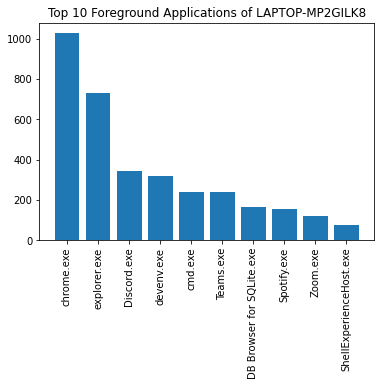

In [20]:
plt.bar(x=foreground_0.index[:10], height=foreground_0.values[:10])
plt.xticks(rotation=90);
plt.title('Top 10 Foreground Applications of LAPTOP-MP2GILK8');

In [21]:
# getting value counts of foreground applications on DESKTOP-E83M0TM
foreground_1 = string_df_1[string_df_1['ID_INPUT'] == 3]['VALUE'].value_counts()
foreground_1

chrome.exe                              495
explorer.exe                            374
Discord.exe                             213
cmd.exe                                 137
Spotify.exe                              96
Among Us.exe                             82
ShellExperienceHost.exe                  59
SearchApp.exe                            54
steamwebhelper.exe                       53
SystemSettings.exe                       50
SndVol.exe                               45
Video.UI.exe                             43
msedge.exe                               42
csgo.exe                                 31
RadeonSoftware.exe                       27
ApplicationFrameHost.exe                 23
StartMenuExperienceHost.exe              23
Zoom.exe                                 18
steam.exe                                18
HxOutlook.exe                            14
r5apex.exe                               14
pythonw.exe                              12
Anaconda3-2021.11-Windows-x86_64

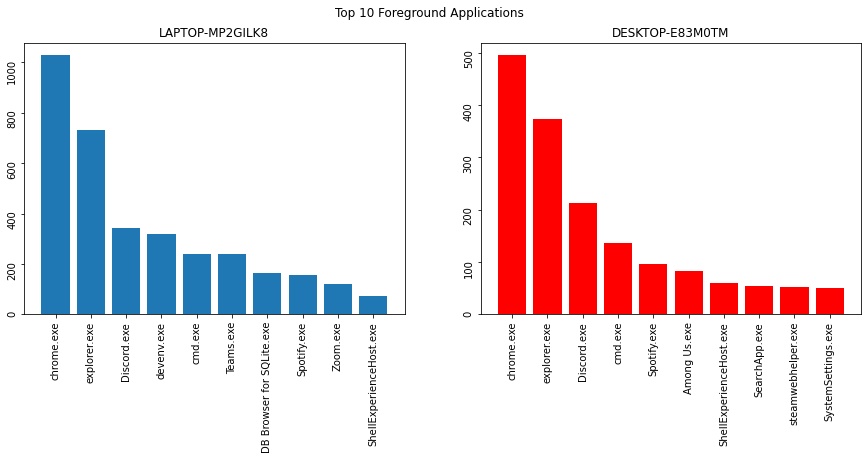

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Top 10 Foreground Applications')

ax1.bar(x=foreground_0.index[:10], height=foreground_0.values[:10])
ax1.tick_params(rotation=90);
ax1.set_title('LAPTOP-MP2GILK8');

ax2.bar(x=foreground_1.index[:10], height=foreground_1.values[:10], color='red')
ax2.tick_params(rotation=90);
ax2.set_title('DESKTOP-E83M0TM');